In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import datetime
import pytz


In [2]:
os.chdir("C:\\Rouhin_Lenovo\\US_project\\GEE_SEBAL_Project\\Csv_Files\\Merged_files")
file_list=os.listdir()
df_list=[]
for i in range(len(file_list)):
    df_list.append(pd.read_csv(file_list[i],parse_dates=["date"]))
    df_list[i]["Name"]=df_list[i][df_list[i]["Name"].notna()]["Name"].iloc[0]
    df_list[i]["Elevation"]=df_list[i][df_list[i]["Elevation"].notna()]["Elevation"].iloc[0]
    df_list[i]["Veg"]=df_list[i][df_list[i]["Veg"].notna()]["Veg"].iloc[0]
    df_list[i]["Clim"]=df_list[i][df_list[i]["Clim"].notna()]["Clim"].iloc[0]
    df_list[i]["MAT (°C)"]=df_list[i][df_list[i]["MAT (°C)"].notna()]["MAT (°C)"].iloc[0]
    df_list[i]["MAP (mm)"]=df_list[i][df_list[i]["MAP (mm)"].notna()]["MAP (mm)"].iloc[0]
    df_list[i]["State"]=df_list[i][df_list[i]["State"].notna()]["State"].iloc[0]
    df_list[i]["Date"]=pd.to_datetime(df_list[i]["Date"])
    df_list[i]=df_list[i].sort_values(by="date")
    df_list[i]=df_list[i][df_list[i].NIR.notna()]


In [3]:
## Now the column names are not the same so we extract all cthe variations of the columns names 
## Then we basically take the most popular column name as first choice and if that doesn't work 
# we take the first element of each list. 
sw_in_list=[]
sw_out_list=[]
TA_list=[]
RH_list=[]
LW_IN_list=[]
LW_OUT_list=[]
NETRAD_list=[]
for i in range(len(df_list)):
    ##
    sw_in_list.append(sorted([col for col in df_list[i].columns if "SW_IN" in col],key=len))
    sw_out_list.append(sorted([col for col in df_list[i].columns if "SW_OUT" in col],key=len))
    TA_list.append(sorted([col for col in df_list[i].columns if col.startswith("TA_")],key=len))
    RH_list.append(sorted([col for col in df_list[i].columns if "RH" in col],key=len))
    LW_IN_list.append(sorted([col for col in df_list[i].columns if "LW_IN" in col],key=len))
    LW_OUT_list.append(sorted([col for col in df_list[i].columns if "LW_OUT" in col],key=len))
    NETRAD_list.append(sorted([col for col in df_list[i].columns if "NETRAD" in col],key=len))


In [4]:
## Store all the variables such that column name of all the data from different stations are similar
for i in range(len(file_list)):
    df_list[i]["SW_IN"]=df_list[i][sw_in_list[i][0]]
    df_list[i]["SW_OUT"]=df_list[i][sw_out_list[i][0]]
    df_list[i]["LW_OUT"]=df_list[i][LW_OUT_list[i][0]]
    df_list[i]["LW_IN"]=df_list[i][LW_IN_list[i][0]]
    df_list[i]["RH"]=df_list[i][RH_list[i][0]]
    df_list[i]["NETRAD"]=df_list[i][NETRAD_list[i][0]]
    if "TA" not in df_list[i].columns:
        df_list[i]["TA"]=df_list[i][TA_list[i][0]]    

In [5]:
for i in range(len(file_list)):
    if df_list[i]["Name"].iloc[0]=="US-Var":
        print(i)
df_list[0].columns

43


Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'longitude', 'latitude', 'date',
       'UB', 'B', 'GR', 'R',
       ...
       'Tao_ding', 'Tao_sebal_insitu', 'Datetime_Local_y', 'SW_IN', 'SW_OUT',
       'LW_OUT', 'LW_IN', 'RH', 'NETRAD', 'TA'],
      dtype='object', length=244)

In [6]:
for i in range(len(file_list)):
    if df_list[i].shape[0]==0:
        print(i)
#     if df_list[i]["Elevation"].iloc[0]>2000:

#         print(i)

In [7]:
df_list[4]["State"]

0      WY
13     WY
14     WY
15     WY
17     WY
       ..
278    WY
280    WY
281    WY
284    WY
287    WY
Name: State, Length: 70, dtype: object

In [8]:
##--- Transmissivity cominations 
## CLear sky emissivities
def angstrom(ea,Ta):
    Ta=Ta+273.16
    emis=0.83-0.18*(10**(-0.67*ea))
    sig= 5.670374419*(10**(-8))
    lw=emis*sig*(Ta**4)
    return lw
def brunt(ea,Ta):
    Ta=Ta+273.16
    emis=(0.52+0.205*(ea)**0.5)
    sig= 5.670374419*(10**(-8))
    lw=emis*sig*(Ta**4)
    return lw
def dilley(ea,Ta):
#     Ta_emis=Ta_emis+273.16
    Ta=Ta+273.16
    lw=59.38+113.7*((Ta/273.16)**6)+96.96*((465*ea/(Ta*2.5))**0.5)
#     print(emis)
#     sig= 5.670374419*(10**(-8))
#     lw=emis*sig*(Ta_lw**4)
    return lw
def sebal(trans,Ta):
    Ta=Ta+273.16
    emis=0.85*(-np.log(trans))**0.09
    sig= 5.670374419*(10**(-8))
    lw=emis*sig*Ta**4
    return lw
def emissivity(df):
    sig=5.670374419e-8
    df["epsilon_actual"]=df["LW_OUT"]/(sig*(df["T_LST_DEM"]**4))
    df["epsilon_sebal"]=df["Rl_up"]/(sig*(df["T_LST_DEM"]**4))

    return df
for i in range(len(df_list)):
##Angstrom with insitu ea and insitu temp 
    df_list[i]["LW_IN_ang_insitu"]=angstrom(df_list[i]["ea"],df_list[i]["TA"])
    df_list[i]["LW_IN_ang_era"]=angstrom(df_list[i]["EA"],df_list[i]["AirT_G"])
    df_list[i]["LW_IN_ang_era_cold"]=angstrom(df_list[i]["EA"],df_list[i]["cold_pixel_temp"]-273.16)
    # brunt 
    df_list[i]["LW_IN_brunt_insitu"]=brunt(df_list[i]["ea"],df_list[i]["TA"])
    df_list[i]["LW_IN_brunt_era"]=brunt(df_list[i]["EA"],df_list[i]["AirT_G"])
    df_list[i]["LW_IN_brunt_cold"]=brunt(df_list[i]["EA"],df_list[i]["cold_pixel_temp"]-273.16)
    ## Dilley is tricky so we will use 
    df_list[i]["LW_IN_dilley_insitu"]=dilley(df_list[i]["ea"],df_list[i]["TA"])
    df_list[i]["LW_IN_dilley_era"]=dilley(df_list[i]["EA"],df_list[i]["AirT_G"])
    df_list[i]["LW_IN_dilley_cold"]=dilley(df_list[i]["EA"],df_list[i]["cold_pixel_temp"]-273.16)
    ## Normal transmissivity 
    df_list[i]["LW_IN_sebal_insitu"]=sebal(df_list[i]["Tao_sw"],df_list[i]["TA"])
    df_list[i]["LW_IN_sebal_era"]=sebal(df_list[i]["Tao_sw"],df_list[i]["AirT_G"])
    df_list[i]["LW_IN_sebal_insitu_tao_mes"]=sebal(df_list[i]["Tao_sw_am"],df_list[i]["TA"])
    df_list[i]["LW_IN_sebal_era_tao_mes"]=sebal(df_list[i]["Tao_sw_am"],df_list[i]["AirT_G"])
    df_list[i]["LW_IN_sebal_cold_tao_mes"]=sebal(df_list[i]["Tao_sw_am"],df_list[i]["cold_pixel_temp"]-273.16)
    ## Upward longwave
    df_list[i]=emissivity(df_list[i])

C:\Users\rouhi\anaconda3\envs\ee-env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rouhi\anaconda3\envs\ee-env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rouhi\anaconda3\envs\ee-env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# df_list[0][(df_list[0]["LW_IN"].notna()) & (df_list[0]["LW_IN_ang_insitu"].notna())  ]["LW_IN"].dropna()
df_list[0][(df_list[0]["LW_OUT"].notna()) & (df_list[0]["Rl_up"].notna())]["LW_IN"].dropna()

0      279.700
1      279.700
50     415.780
52     415.780
53     436.247
        ...   
196    241.087
198    300.777
199    300.777
200    375.273
201    375.273
Name: LW_IN, Length: 106, dtype: float64

In [10]:
# df_list[0][(df_list[0]["LW_IN"].notna())  & (df_list[0]["LW_IN_ang_insitu"].notna())   ]["LW_IN_ang_insitu"].dropna()
df_list[0][ (df_list[0]["LW_OUT"].notna())  & (df_list[0]["Rl_up"].notna()) ]["Rl_up"].dropna()

0      365.415026
1      365.555687
50     532.759090
52     533.052126
53     577.189162
          ...    
196    321.495397
198    402.366252
199    402.436470
200    355.891390
201    355.343121
Name: Rl_up, Length: 106, dtype: float64

In [11]:
for i in range(len(file_list)):
    print(df_list[i][(df_list[i]["NETRAD"].notna())  & (df_list[i]["Rn"].notna())  ]["Rn"].shape)
    print(df_list[i][(df_list[i]["NETRAD"].notna())  & (df_list[i]["Rn"].notna())  ]["NETRAD"].shape)

(2,)
(2,)
(183,)
(183,)
(154,)
(154,)
(53,)
(53,)
(10,)
(10,)
(28,)
(28,)
(165,)
(165,)
(23,)
(23,)
(73,)
(73,)
(88,)
(88,)
(29,)
(29,)
(195,)
(195,)
(0,)
(0,)
(89,)
(89,)
(73,)
(73,)
(70,)
(70,)
(47,)
(47,)
(44,)
(44,)
(75,)
(75,)
(144,)
(144,)
(80,)
(80,)
(58,)
(58,)
(67,)
(67,)
(112,)
(112,)
(102,)
(102,)
(115,)
(115,)
(50,)
(50,)
(58,)
(58,)
(108,)
(108,)
(81,)
(81,)
(28,)
(28,)
(96,)
(96,)
(72,)
(72,)
(73,)
(73,)
(91,)
(91,)
(116,)
(116,)
(118,)
(118,)
(59,)
(59,)
(327,)
(327,)
(76,)
(76,)
(30,)
(30,)
(29,)
(29,)
(21,)
(21,)
(333,)
(333,)
(126,)
(126,)
(131,)
(131,)
(35,)
(35,)
(74,)
(74,)
(52,)
(52,)
(100,)
(100,)
(108,)
(108,)
(153,)
(153,)
(100,)
(100,)
(117,)
(117,)
(69,)
(69,)
(109,)
(109,)
(168,)
(168,)
(169,)
(169,)
(41,)
(41,)
(50,)
(50,)
(39,)
(39,)
(129,)
(129,)
(100,)
(100,)
(14,)
(14,)
(30,)
(30,)
(46,)
(46,)
(132,)
(132,)
(50,)
(50,)
(44,)
(44,)
(120,)
(120,)
(57,)
(57,)
(68,)
(68,)
(74,)
(74,)
(54,)
(54,)
(36,)
(36,)
(39,)
(39,)
(48,)
(48,)
(40,)
(40,)
(72,)
(72,)
(2

In [12]:
## Site wide statistics 
# First join all stations together
all_data=pd.concat(df_list)
## Calculating RMSE for each site for each variable
from sklearn.metrics import mean_squared_error 
rmse_sw_in=[]
rmse_lw_in=[]
rmse_lw_out=[]
rmse_albedo=[]
rmse_netrad=[]
rmse_trans=[]
rmse_lw_in_ang_insitu=[]
rmse_lw_in_ang_era=[]
rmse_lw_in_ang_era_cold=[]
rmse_lw_in_brunt_insitu=[]
rmse_lw_in_brunt_era=[]
rmse_lw_in_brunt_era_cold=[]
rmse_lw_in_dilley_era_cold=[]
rmse_lw_in_dilley_era=[]
rmse_lw_in_dilley_insitu=[]
#
rmse_lw_in_sebal_era=[]
rmse_lw_in_sebal_insitu=[]
#name of station
name=[]
# Elevation
elev=[]
#Climate
clim=[]
#veeg 
veg=[]
for i in range(len(df_list)):
    rmse_sw_in.append(mean_squared_error(df_list[i][df_list[i]["SW_IN"].notna()]["SW_IN"], df_list[i][df_list[i]["SW_IN"].notna()]["Rs_down"],squared=False))
    rmse_lw_in.append(mean_squared_error(df_list[i][df_list[i]["LW_IN"].notna()]["LW_IN"], df_list[i][df_list[i]["LW_IN"].notna()]["Rl_down"],squared=False))
    if df_list[i][(df_list[i]["LW_OUT"].notna())  & (df_list[i]["Rl_up"].notna())  ]["LW_OUT"].shape[0]>0:
        rmse_lw_out.append(mean_squared_error(df_list[i][(df_list[i]["LW_OUT"].notna())  & (df_list[i]["Rl_up"].notna())  ]["LW_OUT"], df_list[i][(df_list[i]["LW_OUT"].notna())  & (df_list[i]["Rl_up"].notna())  ]["Rl_up"],squared=False))
    else:
        rmse_lw_out.append(np.nan)
    if df_list[i][(df_list[i]["NETRAD"].notna())  & (df_list[i]["Rn"].notna())  ]["NETRAD"].shape[0]>0:
        rmse_netrad.append(mean_squared_error(df_list[i][(df_list[i]["NETRAD"].notna()) & (df_list[i]["Rn"].notna())   ]["NETRAD"], df_list[i][(df_list[i]["NETRAD"].notna()) & (df_list[i]["Rn"].notna())  ]["Rn"],squared=False))
    else:
        rmse_netrad.append(np.nan)        
    rmse_albedo.append(mean_squared_error(df_list[i][(df_list[i]["Albedo"].notna())  & (df_list[i]["ALFA"].notna())  ]["Albedo"], df_list[i][(df_list[i]["Albedo"].notna())  & (df_list[i]["ALFA"].notna())  ]["ALFA"],squared=False))
    rmse_trans.append(mean_squared_error(df_list[i][df_list[i]["Tao_sw_am"].notna()]["Tao_sw_am"], df_list[i][df_list[i]["Tao_sw_am"].notna()]["Tao_sw"],squared=False))
    ## More lw 
#     ang
    rmse_lw_in_ang_insitu.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_insitu"].notna())]["LW_IN_ang_insitu"].dropna(),squared=False))
    rmse_lw_in_ang_era.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era"].notna())]["LW_IN_ang_era"].dropna(),squared=False))
    rmse_lw_in_ang_era_cold.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era_cold"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era_cold"].notna())]["LW_IN_ang_era_cold"].dropna(),squared=False))
#brunt
    rmse_lw_in_brunt_insitu.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_insitu"].notna())]["LW_IN_brunt_insitu"].dropna(),squared=False))
    rmse_lw_in_brunt_era.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_era"].notna())]["LW_IN_brunt_era"].dropna(),squared=False))
    rmse_lw_in_brunt_era_cold.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_cold"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_cold"].notna())]["LW_IN_brunt_cold"].dropna(),squared=False))
# Dilley 
    rmse_lw_in_dilley_insitu.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_insitu"].notna())]["LW_IN_dilley_insitu"].dropna(),squared=False))
    rmse_lw_in_dilley_era.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_era"].notna())]["LW_IN_dilley_era"].dropna(),squared=False))
    rmse_lw_in_dilley_era_cold.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_cold"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_cold"].notna())]["LW_IN_dilley_cold"].dropna(),squared=False))
    rmse_lw_in_sebal_era.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_era"].notna())]["LW_IN_sebal_era"].dropna(),squared=False))

    rmse_lw_in_sebal_insitu.append(mean_squared_error(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_insitu"].notna())]["LW_IN_sebal_insitu"].dropna(),squared=False))

#name
    name.append(df_list[i]["Name"].iloc[0])
    elev.append(df_list[i]["Elevation"].iloc[0])
    clim.append(df_list[i]["Clim"].iloc[0])
    veg.append(df_list[i]["Veg"].iloc[0])
##
summary_df=pd.DataFrame()
summary_df["rmse_sw_in"],summary_df["rmse_lw_in"],summary_df["rmse_albedo"]=rmse_sw_in,rmse_lw_in,rmse_albedo
summary_df["rmse_lw_out"],summary_df["rmse_netrad"],summary_df["rmse_trans"]=rmse_lw_out,rmse_netrad,rmse_trans
summary_df["rmse_lw_in_ang_insitu"],summary_df["rmse_lw_in_ang_era"],summary_df["rmse_lw_in_ang_era_cold"]=\
rmse_lw_in_ang_insitu,rmse_lw_in_ang_era,rmse_lw_in_ang_era_cold
summary_df["rmse_lw_in_brunt_insitu"],summary_df["rmse_lw_in_brunt_era"],summary_df["rmse_lw_in_brunt_era_cold"]=\
rmse_lw_in_brunt_insitu,rmse_lw_in_brunt_era,rmse_lw_in_brunt_era_cold
summary_df["rmse_lw_in_dilley_insitu"],summary_df["rmse_lw_in_dilley_era"],summary_df["rmse_lw_in_dilley_era_cold"]=\
rmse_lw_in_dilley_insitu,rmse_lw_in_dilley_era,rmse_lw_in_dilley_era_cold
summary_df["rmse_lw_in_sebal_era"]=rmse_lw_in_sebal_era
summary_df["rmse_lw_in_sebal_insitu"]=rmse_lw_in_sebal_insitu
##
summary_df["Elevation"]=elev
summary_df["Name"]=name
summary_df["Veg"]=veg
summary_df["Clim"]=clim


In [13]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(( Y_Predicted-Y_actual)/Y_actual)*100
    return mape

In [14]:
# from sklearn.metrics import MAPE 
bias_sw_in=[]
bias_lw_in=[]
bias_lw_out=[]
bias_albedo=[]
bias_netrad=[]
bias_trans=[]
bias_lw_in_ang_insitu=[]
bias_lw_in_ang_era=[]
bias_lw_in_ang_era_cold=[]
bias_lw_in_brunt_insitu=[]
bias_lw_in_brunt_era=[]
bias_lw_in_brunt_era_cold=[]
bias_lw_in_dilley_era_cold=[]
bias_lw_in_dilley_era=[]
bias_lw_in_dilley_insitu=[]
#
bias_lw_in_sebal_era=[]
bias_lw_in_sebal_insitu=[]
#name of station
name=[]
# Elevation
elev=[]
#Climate
clim=[]
#veeg 
veg=[]
for i in range(len(df_list)):
    bias_sw_in.append(MAPE(df_list[i][df_list[i]["SW_IN"].notna()]["SW_IN"], df_list[i][df_list[i]["SW_IN"].notna()]["Rs_down"]))
    bias_lw_in.append(MAPE(df_list[i][df_list[i]["LW_IN"].notna()]["LW_IN"], df_list[i][df_list[i]["LW_IN"].notna()]["Rl_down"]))
    if df_list[i][(df_list[i]["LW_OUT"].notna())  & (df_list[i]["Rl_up"].notna())  ]["LW_OUT"].shape[0]>0:
        bias_lw_out.append(MAPE(df_list[i][(df_list[i]["LW_OUT"].notna())  & (df_list[i]["Rl_up"].notna())  ]["LW_OUT"], df_list[i][(df_list[i]["LW_OUT"].notna())  & (df_list[i]["Rl_up"].notna())  ]["Rl_up"]))
    else:
        bias_lw_out.append(np.nan)
    if df_list[i][(df_list[i]["NETRAD"].notna())  & (df_list[i]["Rn"].notna())  ]["NETRAD"].shape[0]>0:
        bias_netrad.append(MAPE(df_list[i][(df_list[i]["NETRAD"].notna()) & (df_list[i]["Rn"].notna())   ]["NETRAD"], df_list[i][(df_list[i]["NETRAD"].notna()) & (df_list[i]["Rn"].notna())  ]["Rn"]))
    else:
        bias_netrad.append(np.nan)        
    bias_albedo.append(MAPE(df_list[i][(df_list[i]["Albedo"].notna())  & (df_list[i]["ALFA"].notna())  ]["Albedo"], df_list[i][(df_list[i]["Albedo"].notna())  & (df_list[i]["ALFA"].notna())  ]["ALFA"]))
    bias_trans.append(MAPE(df_list[i][df_list[i]["Tao_sw_am"].notna()]["Tao_sw_am"], df_list[i][df_list[i]["Tao_sw_am"].notna()]["Tao_sw"]))
    ## More lw 
#     ang
    bias_lw_in_ang_insitu.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_insitu"].notna())]["LW_IN_ang_insitu"].dropna()))
    bias_lw_in_ang_era.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era"].notna())]["LW_IN_ang_era"].dropna()))
    bias_lw_in_ang_era_cold.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era_cold"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_ang_era_cold"].notna())]["LW_IN_ang_era_cold"].dropna()))
#brunt
    bias_lw_in_brunt_insitu.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_insitu"].notna())]["LW_IN_brunt_insitu"].dropna()))
    bias_lw_in_brunt_era.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_era"].notna())]["LW_IN_brunt_era"].dropna()))
    bias_lw_in_brunt_era_cold.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_cold"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_brunt_cold"].notna())]["LW_IN_brunt_cold"].dropna()))
# Dilley 
    bias_lw_in_dilley_insitu.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_insitu"].notna())]["LW_IN_dilley_insitu"].dropna()))
    bias_lw_in_dilley_era.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_era"].notna())]["LW_IN_dilley_era"].dropna()))
    bias_lw_in_dilley_era_cold.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_cold"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_dilley_cold"].notna())]["LW_IN_dilley_cold"].dropna()))
    bias_lw_in_sebal_era.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_era"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_era"].notna())]["LW_IN_sebal_era"].dropna()))

    bias_lw_in_sebal_insitu.append(MAPE(df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_insitu"].notna())]["LW_IN"].dropna() \
                                                    , df_list[i][(df_list[i]["LW_IN"].notna()) & (df_list[i]["LW_IN_sebal_insitu"].notna())]["LW_IN_sebal_insitu"].dropna()))

#name
    name.append(df_list[i]["Name"].iloc[0])
    elev.append(df_list[i]["Elevation"].iloc[0])
    clim.append(df_list[i]["Clim"].iloc[0])
    veg.append(df_list[i]["Veg"].iloc[0])
##
summary_bias_df=pd.DataFrame()
summary_bias_df["bias_sw_in"],summary_bias_df["bias_lw_in"],summary_bias_df["bias_albedo"]=bias_sw_in,bias_lw_in,bias_albedo
summary_bias_df["bias_lw_out"],summary_bias_df["bias_netrad"],summary_bias_df["bias_trans"]=bias_lw_out,bias_netrad,bias_trans
summary_bias_df["bias_lw_in_ang_insitu"],summary_bias_df["bias_lw_in_ang_era"],summary_bias_df["bias_lw_in_ang_era_cold"]=\
bias_lw_in_ang_insitu,bias_lw_in_ang_era,bias_lw_in_ang_era_cold
summary_bias_df["bias_lw_in_brunt_insitu"],summary_bias_df["bias_lw_in_brunt_era"],summary_bias_df["bias_lw_in_brunt_era_cold"]=\
bias_lw_in_brunt_insitu,bias_lw_in_brunt_era,bias_lw_in_brunt_era_cold
summary_bias_df["bias_lw_in_dilley_insitu"],summary_bias_df["bias_lw_in_dilley_era"],summary_bias_df["bias_lw_in_dilley_era_cold"]=\
bias_lw_in_dilley_insitu,bias_lw_in_dilley_era,bias_lw_in_dilley_era_cold
summary_bias_df["bias_lw_in_sebal_era"]=bias_lw_in_sebal_era
summary_bias_df["bias_lw_in_sebal_insitu"]=bias_lw_in_sebal_insitu
##
summary_bias_df["Elevation"]=elev
summary_bias_df["Name"]=name
summary_bias_df["Veg"]=veg
summary_bias_df["Clim"]=clim


In [15]:
for i in range(len(df_list)):
    if df_list[i]["Elevation"].iloc[0]>2000:
        print(i)

4
19
26
29
63
64
75
79


Text(0.5, 1.0, 'LW_IN')

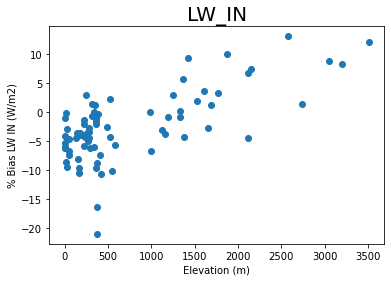

In [99]:
# import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_lw_in"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("% Bias LW IN (W/m2)")
plt.title("LW_IN", fontsize=20)

Text(0.5, 1.0, 'Albedo')

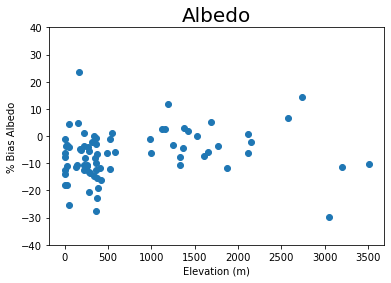

In [107]:
# import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_albedo"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("% Bias Albedo")
plt.ylim(-40,40)
plt.title("Albedo", fontsize=20)

Text(0.5, 1.0, 'SW IN')

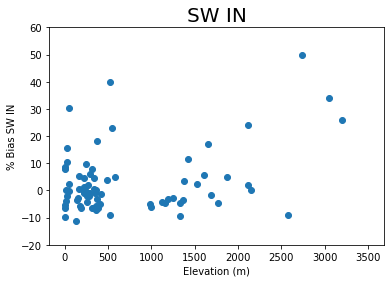

In [114]:
# import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_sw_in"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("% Bias SW IN")
plt.ylim(-20,60)
plt.title("SW IN", fontsize=20)

Text(0.5, 1.0, 'LW IN')

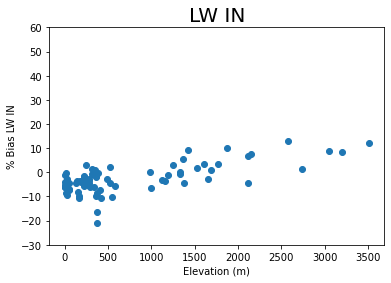

In [117]:
# import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_lw_in"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("% Bias LW IN")
plt.ylim(-30,60)
plt.title("LW IN", fontsize=20)

Text(0.5, 1.0, 'NETRAD')

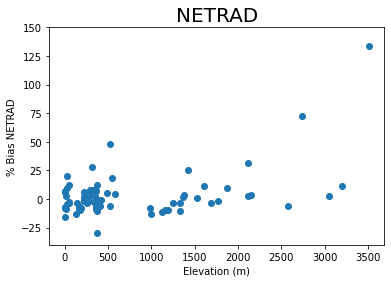

In [137]:
# import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_netrad"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("% Bias NETRAD")
plt.ylim(-40,150)
plt.title("NETRAD", fontsize=20)

In [ ]:
# import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_lw_out"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("% Bias LW OUT")
plt.ylim(-10,10)
plt.title("LW OUT", fontsize=20)

Text(0.5, 1.0, 'Transmissivity')

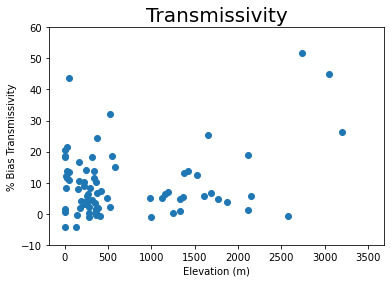

In [129]:
# import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_trans"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("% Bias Transmissivity")
plt.ylim(-10,60)
plt.title("Transmissivity", fontsize=20)

Text(0.5, 1.0, 'SEBAL LW IN')

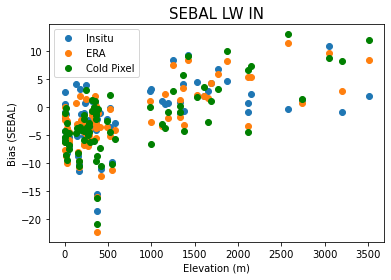

In [126]:
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_lw_in_sebal_insitu"],"o",label="Insitu")
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_lw_in_sebal_era"],"o",label="ERA")
plt.plot(summary_bias_df["Elevation"],summary_bias_df["bias_lw_in"],"o",c="g",label="Cold Pixel")
plt.xlabel("Elevation (m)")
plt.ylabel("Bias (SEBAL)")
plt.legend()
# plt.ylim(10,70)
plt.title("SEBAL LW IN",fontsize=15)

Text(0, 0.5, 'RMSE Albedo')

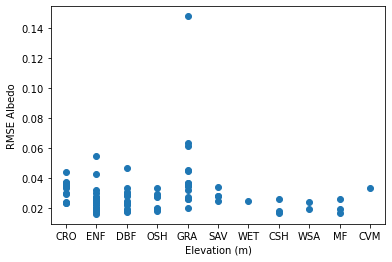

In [73]:
plt.plot(summary_df["Veg"],summary_df["rmse_albedo"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE Albedo")

Text(0, 0.5, 'RMSE Transmissivity')

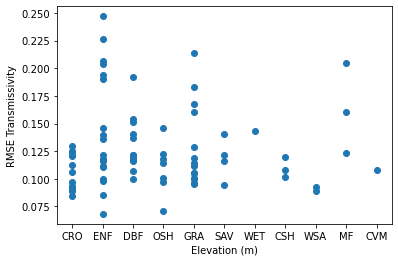

In [74]:
plt.plot(summary_df["Veg"],summary_df["rmse_trans"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE Transmissivity")

Text(0.5, 1.0, 'SEBAL LW IN')

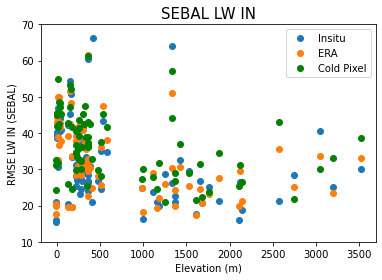

In [123]:
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_sebal_insitu"],"o",label="Insitu")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_sebal_era"],"o",label="ERA")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in"],"o",c="g",label="Cold Pixel")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE LW IN (SEBAL)")
plt.legend()
plt.ylim(10,70)
plt.title("SEBAL LW IN",fontsize=15)

Text(0.5, 1.0, 'LW IN (Angstrom Emissivity)')

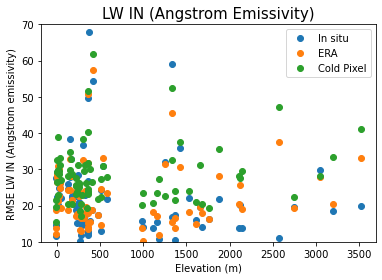

In [69]:
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_ang_insitu"],"o",label="In situ")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_ang_era"],"o",label="ERA")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_ang_era_cold"],"o",label="Cold Pixel")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE LW IN (Angstrom emissivity)")
plt.legend()
plt.ylim(10,70)
plt.title("LW IN (Angstrom Emissivity)",fontsize=15)

Text(0.5, 1.0, 'LW IN (Brunt Emissivity)')

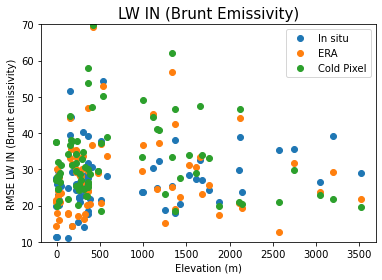

In [70]:
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_brunt_insitu"],"o",label="In situ")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_brunt_era"],"o",label="ERA")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_brunt_era_cold"],"o",label="Cold Pixel")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE LW IN (Brunt emissivity)")
plt.legend()
plt.ylim(10,70)
plt.title("LW IN (Brunt Emissivity)",fontsize=15)

Text(0.5, 1.0, 'LW IN (Dilley)')

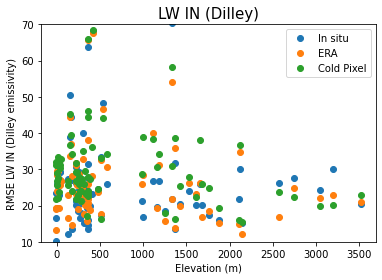

In [71]:
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_dilley_insitu"],"o",label="In situ")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_dilley_era"],"o",label="ERA")
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_in_dilley_era_cold"],"o",label="Cold Pixel")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE LW IN (Dilley emissivity)")
plt.legend()
plt.ylim(10,70)
plt.title("LW IN (Dilley)",fontsize=15)

Text(0, 0.5, 'RMSE LW OUT')

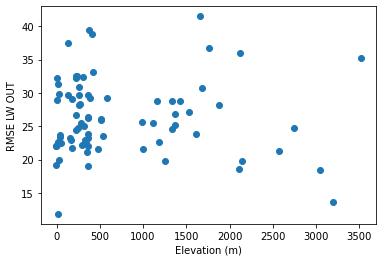

In [52]:
plt.plot(summary_df["Elevation"],summary_df["rmse_lw_out"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE LW OUT")

Text(0, 0.5, 'RMSE LW IN')

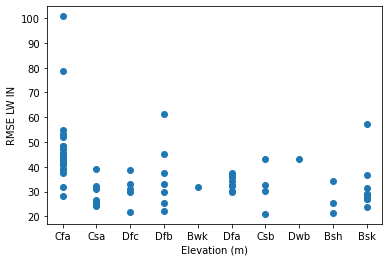

In [76]:
plt.plot(summary_df["Clim"],summary_df["rmse_lw_in"],"o")
plt.xlabel("Elevation (m)")
plt.ylabel("RMSE LW IN")

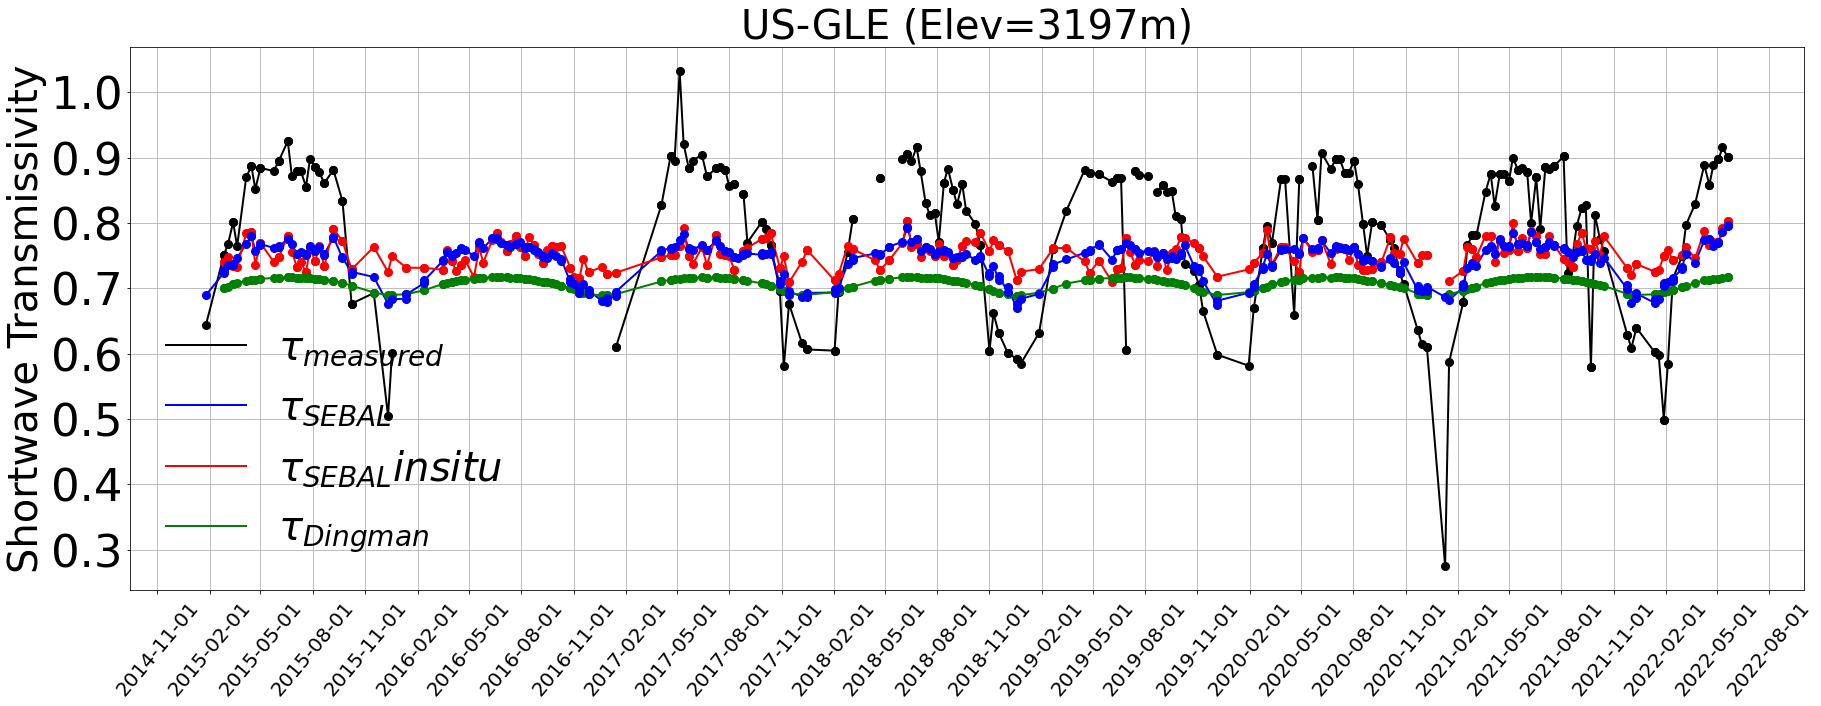

In [56]:
### 
## Plot ET timeseries 
import datetime
import matplotlib.dates as mdates
fig,ax=plt.subplots(figsize=(30,10))
from matplotlib.dates import MonthLocator, DateFormatter

date_format = mdates.DateFormatter('%d\n%b')
# ax2=ax.twinx()
# ax.plot(svt["Date"],svt['24_south'],c="b",label="$\sigma_{vv}$",linewidth=5)
# ax.plot(svt["Date"],svt['36_south'],c="r",label="$\sigma_{vv}$",linewidth=5)

# ax2.plot(lai["Date"],lai['LAI'],c="r",label="ETo Actual",linewidth=5)
ax.plot(df_list[43]["Date"],df_list[43]['Tao_sw_am'],c="k",label=r"$\tau_{measured}$",linewidth=2)
# ax.plot(df_list[43]["Date"],df_list[43]['LE']/28.36,c="c",label="ETc",linewidth=5)

ax.plot(df_list[43]["Date"],df_list[43]['Tao_sw'],c="b",label=r"$\tau_{SEBAL}$",linewidth=2)
ax.plot(df_list[43]["Date"],df_list[43]['Tao_sw_am'],"o",c="k",linewidth=5,markersize=8)
# ax.plot(df_list[43]["Date"],df_list[43]['LE']/28.36,c="c",label="ETc",linewidth=5)

ax.plot(df_list[43]["Date"],df_list[43]["Tao_sebal_insitu"],c="r",label=r"$\tau_{SEBAL} insitu$",linewidth=2)
ax.plot(df_list[43]["Date"],df_list[43]["Tao_sebal_insitu"],"o",c="r",linewidth=5,markersize=8)

ax.plot(df_list[43]["Date"],df_list[43]['Tao_ding'],c="g",label=r"$\tau_{Dingman}$",linewidth=2)
ax.plot(df_list[43]["Date"],df_list[43]["Tao_ding"],"o",c="g",linewidth=5,markersize=8)

ax.plot(df_list[43]["Date"],df_list[43]['Tao_sw'],"o",c="b",linewidth=5,markersize=8)
# ax.plot(df_list[43]["Date"],df_list[43]['PT_ETo']/28.36,c="g",label="ETo PT",linewidth=5)
# ax.plot(df_list[43]["Date"],df_list[43]['ETo_SdB']/28.36,c="y",label="ETo SdB",linewidth=5)

# ax.plot(df_list[43]["Date"],df_list[43]['ETo_SdB'],"--",c="y",label="ETo SdB(I)",linewidth=5)
# ax.plot(df_list[43]["Date"],df_list[43]['ETo_Ensemble'],c="k",label="ETo Ensemble(NI)",linewidth=5)
# ax.plot(svt["Date"],svt["LE"],"--",c="m",label="Actual ET(I)",linewidth=4)
# ax.plot(df_list[43]["Date"],df_list[43]['LE'],"--",c="c",label="Actual ET",linewidth=5)


ax.xaxis.set_major_locator(MonthLocator(interval=90))
# ax.set_title("south svt Station",fontsize=35)
ax.set_ylabel("Shortwave Transmissivity",fontsize=40)
# ax.axvline(datetime.datetime(2021, 2, 25),c="g",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 4, 9),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 5, 14),c="g",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 6, 10),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 7, 12),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 8, 14),c="g",linewidth=5,linestyle="--")

# ax.axhline(20,c="r",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 6, 19),c="r",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 9, 24),c="r",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 6, 10),c="g",linewidth=5,linestyle="--")

ax.grid()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.set_title("US-GLE (Elev=3197m)",fontsize=40)

# ax.set_xticklabels(["May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],fontsize=45)

# # ax.set_ylim(20,220)
plt.xticks(fontsize=20,rotation=50)
plt.yticks(fontsize=45)
# plt.xticks(fontsize=25)
ax.legend(fontsize=40,loc="lower left",frameon=False)
# ax.axvspan("2021-06-10","2021-07-14", facecolor='green', alpha=0.1)
# plt.savefig("C:\\Rouhin_Lenovo\\US_project\\US_Project\\CIMIS\\Figures\\EC_Station_south_yield1_actual.png",dpi=300,bbox_inches="tight")

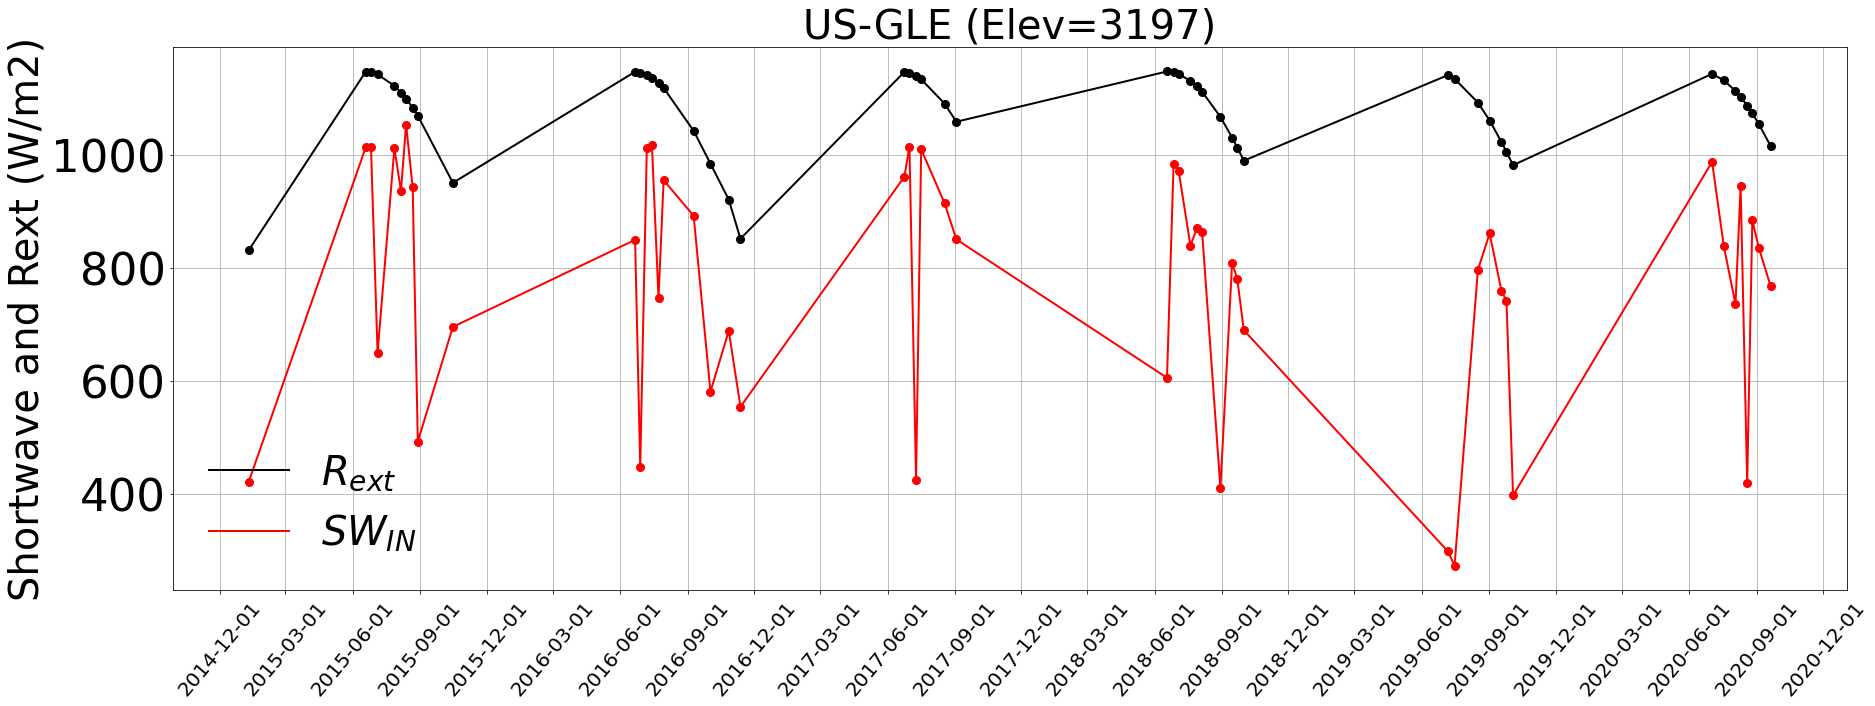

In [55]:
### 
## Plot ET timeseries 
import datetime
import matplotlib.dates as mdates
fig,ax=plt.subplots(figsize=(30,10))
from matplotlib.dates import MonthLocator, DateFormatter

date_format = mdates.DateFormatter('%d\n%b')
# ax2=ax.twinx()
# ax.plot(svt["Date"],svt['24_south'],c="b",label="$\sigma_{vv}$",linewidth=5)
# ax.plot(svt["Date"],svt['36_south'],c="r",label="$\sigma_{vv}$",linewidth=5)

# ax2.plot(lai["Date"],lai['LAI'],c="r",label="ETo Actual",linewidth=5)
ax.plot(df_list[4]["Date"],df_list[4]['Rext'],c="k",label=r"$R_{ext}$",linewidth=2)
# ax.plot(df_list[4]["Date"],df_list[4]['LE']/28.36,c="c",label="ETc",linewidth=5)

# ax.plot(df_list[4]["Date"],df_list[4]['Tao_sw'],c="b",label=r"$\tau_{SEBAL}$",linewidth=2)
ax.plot(df_list[4]["Date"],df_list[4]['Rext'],"o",c="k",linewidth=5,markersize=8)
# ax.plot(df_list[4]["Date"],df_list[4]['LE']/28.36,c="c",label="ETc",linewidth=5)

ax.plot(df_list[4]["Date"],df_list[4]["SW_IN_1_1_1"],c="r",label=r"$SW_{IN}$",linewidth=2)
ax.plot(df_list[4]["Date"],df_list[4]["SW_IN_1_1_1"],"o",c="r",linewidth=5,markersize=8)


# ax.plot(df_list[4]["Date"],df_list[4]['Tao_sw'],"o",c="b",linewidth=5,markersize=8)
# ax.plot(df_list[4]["Date"],df_list[4]['PT_ETo']/28.36,c="g",label="ETo PT",linewidth=5)
# ax.plot(df_list[4]["Date"],df_list[4]['ETo_SdB']/28.36,c="y",label="ETo SdB",linewidth=5)

# ax.plot(df_list[4]["Date"],df_list[4]['ETo_SdB'],"--",c="y",label="ETo SdB(I)",linewidth=5)
# ax.plot(df_list[4]["Date"],df_list[4]['ETo_Ensemble'],c="k",label="ETo Ensemble(NI)",linewidth=5)
# ax.plot(svt["Date"],svt["LE"],"--",c="m",label="Actual ET(I)",linewidth=4)
# ax.plot(df_list[4]["Date"],df_list[4]['LE'],"--",c="c",label="Actual ET",linewidth=5)


ax.xaxis.set_major_locator(MonthLocator(interval=90))
# ax.set_title("south svt Station",fontsize=35)
ax.set_ylabel("Shortwave and Rext (W/m2)",fontsize=40)
# ax.axvline(datetime.datetime(2021, 2, 25),c="g",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 4, 9),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 5, 14),c="g",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 6, 10),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 7, 12),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 8, 14),c="g",linewidth=5,linestyle="--")

# ax.axhline(20,c="r",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 6, 19),c="r",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 9, 24),c="r",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 6, 10),c="g",linewidth=5,linestyle="--")

ax.grid()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.set_title("US-GLE (Elev=3197)",fontsize=40)

# ax.set_xticklabels(["May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],fontsize=45)

# # ax.set_ylim(20,220)
plt.xticks(fontsize=20,rotation=50)
plt.yticks(fontsize=45)
# plt.xticks(fontsize=25)
ax.legend(fontsize=40,loc="lower left",frameon=False)
# ax.axvspan("2021-06-10","2021-07-14", facecolor='green', alpha=0.1)
# plt.savefig("C:\\Rouhin_Lenovo\\US_project\\US_Project\\CIMIS\\Figures\\EC_Station_south_yield1_actual.png",dpi=300,bbox_inches="tight")

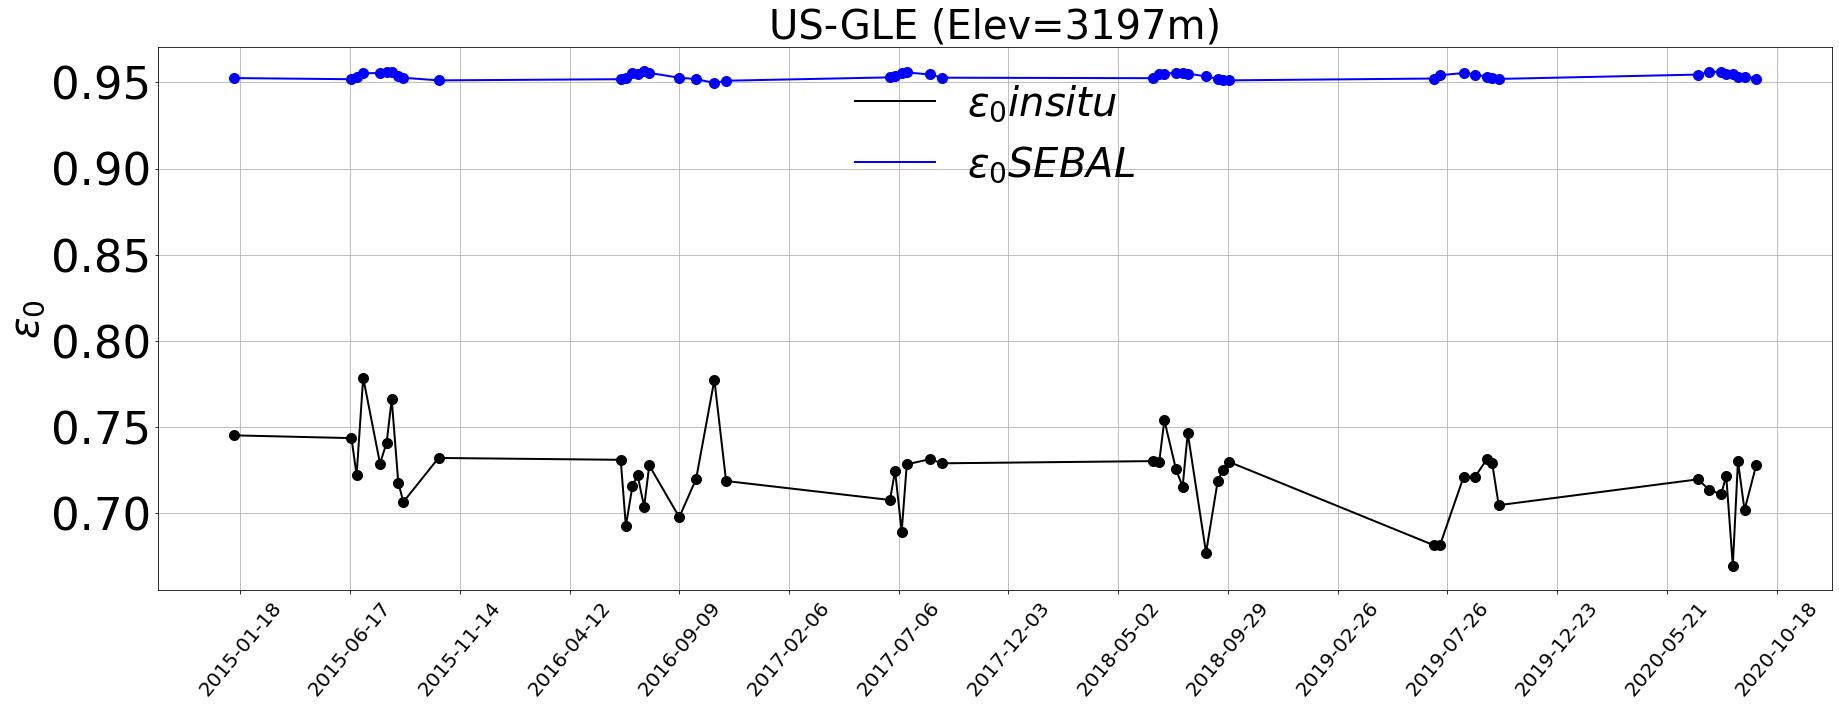

In [95]:
### 
## Plot ET timeseries 
import datetime
import matplotlib.dates as mdates
fig,ax=plt.subplots(figsize=(30,10))
from matplotlib.dates import MonthLocator, DateFormatter

date_format = mdates.DateFormatter('%d\n%b')
# ax2=ax.twinx()
# ax.plot(svt["Date"],svt['24_south'],c="b",label="$\sigma_{vv}$",linewidth=5)
# ax.plot(svt["Date"],svt['36_south'],c="r",label="$\sigma_{vv}$",linewidth=5)

# ax2.plot(lai["Date"],lai['LAI'],c="r",label="ETo Actual",linewidth=5)
ax.plot(df_list[4]["Date"],df_list[4]['epsilon_actual'],c="k",label="$\epsilon_{0} insitu $",linewidth=2)
# ax.plot(df_list[4]["Date"],df_list[4]['LE']/28.36,c="c",label="ETc",linewidth=5)

ax.plot(df_list[4]["Date"],df_list[4]['e_0'],c="b",label="$\epsilon_{0} SEBAL $",linewidth=2)
ax.plot(df_list[4]["Date"],df_list[4]['epsilon_actual'],"o",c="k",linewidth=5,markersize=10)
# ax.plot(df_list[4]["Date"],df_list[4]['LE']/28.36,c="c",label="ETc",linewidth=5)


ax.plot(df_list[4]["Date"],df_list[4]['e_0'],"o",c="b",linewidth=5,markersize=10)


# ax.plot(df_list[4]["Date"],df_list[4]['PT_ETo']/28.36,c="g",label="ETo PT",linewidth=5)
# ax.plot(df_list[4]["Date"],df_list[4]['ETo_SdB']/28.36,c="y",label="ETo SdB",linewidth=5)

# ax.plot(df_list[4]["Date"],df_list[4]['ETo_SdB'],"--",c="y",label="ETo SdB(I)",linewidth=5)
# ax.plot(df_list[4]["Date"],df_list[4]['ETo_Ensemble'],c="k",label="ETo Ensemble(NI)",linewidth=5)
# ax.plot(svt["Date"],svt["LE"],"--",c="m",label="Actual ET(I)",linewidth=4)
# ax.plot(df_list[4]["Date"],df_list[4]['LE'],"--",c="c",label="Actual ET",linewidth=5)


ax.xaxis.set_major_locator(MonthLocator(interval=90))
# ax.set_title("south svt Station",fontsize=35)
ax.set_ylabel("$\epsilon_{0}$",fontsize=40)
# ax.axvline(datetime.datetime(2021, 2, 25),c="g",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 4, 9),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 5, 14),c="g",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 6, 10),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 7, 12),c="g",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 8, 14),c="g",linewidth=5,linestyle="--")

# ax.axhline(20,c="r",linewidth=5,linestyle="--")

# ax.axvline(datetime.datetime(2021, 6, 19),c="r",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 9, 24),c="r",linewidth=5,linestyle="--")
# ax.axvline(datetime.datetime(2021, 6, 10),c="g",linewidth=5,linestyle="--")

ax.grid()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=150))
ax.set_title("US-GLE (Elev=3197m)",fontsize=40)

# ax.set_xticklabels(["May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],fontsize=45)
# ax.set_ylim(0.9,1.2)
# # ax.set_ylim(20,220)
plt.xticks(fontsize=20,rotation=50)
plt.yticks(fontsize=45)
# plt.xticks(fontsize=25)
ax.legend(fontsize=40,loc="upper center",frameon=False)
# ax.axvspan("2021-06-10","2021-07-14", facecolor='green', alpha=0.1)
# plt.savefig("C:\\Rouhin_Lenovo\\US_project\\US_Project\\CIMIS\\Figures\\EC_Station_south_yield1_actual.png",dpi=300,bbox_inches="tight")

In [94]:
df_list[4]["Name"].describe()

count         70
unique         1
top       US-GLE
freq          70
Name: Name, dtype: object

In [ ]:
def calc_errorrs(df):
    ## Error in SW_IN
    df_copy=df.copy()
    df_copy["SW_IN_Bias"]=(df_copy["Rs_down"]-df["SW_IN"])/df["SW_IN"].mean()
    df_copy["Albedo_bias"]=(df_copy["ALFA"]-df_copy["Albedo"])/df["Albedo"])
    